In [35]:
using Plots
using Images
using DifferentialEquations

# Tarea 1

Resuelve todos los ejercicios. Todos tienen el mismo valor aunque algunos son claramente más complicados. 

La tarea está separada en 2 secciones, la primera es de Bases de Julia. Te pido resuelvas sin ayuda, excepto quizá la documentación de Julia y los notebooks que hemos visto. 

La segunda sección es sobre ecuaciones diferenciales, donde estudiaremos algunos modelos de difusión de enfermedades. 

## Bases de Julia

[1]  Haz una función en una sola línea que encuentre el número de primos relativos a $n$ menores que $n$

In [36]:
function primosrel(n)
    
    c = 0

    for i in 1:n  # checa todos los enteros hasta "n"
        if gcd(i, n) == 1  # la definición de wikipedia de "primo relativo"
            c += 1  # agregamos al contador
        else
            nothing
        end
    end
    return c

end

primosrel (generic function with 1 method)

In [37]:
N = primosrel(10)

println(N)

4


[2] Haz una función (de una sola línea) que calcule el área de un polígono dados sus vértices de forma ordenada. 

Usa la fórmula de $$A = \frac 1 2 \sum_{i=1}^n (y_i + y_{i+1})(x_i - x_{i+1})$$

In [38]:
# T = [(x1, y1), ..., (xn, yn)]

function area1(T)

    n = length(T)

    s = [(T[i][2] + T[mod1((i + 1), n)][2])*(T[i][1] - T[mod1((i + 1), n)][1]) for i in 1:n]

    A = 0.5 * sum(s)

    return abs(A)

end

# y en una sóla línea

area2(T) = abs(0.5 * sum([(T[i][2] + T[mod1((i + 1), length(T))][2])*(T[i][1] - T[mod1((i + 1), length(T))][1]) for i in 1:length(T)]))

# o sin usar "list comprehension"

function area(T)

    n = length(T)

    s = []

    for i in 1:n

        elemento = (T[i][2] + T[mod1(i + 1, n)][2]) * (T[i][1] - T[mod1(i + 1, n)][1])

        push!(s, elemento)
    end

    A = 0.5 * sum(s)

    return abs(A)
end

area (generic function with 1 method)

In [39]:
T1 = [(0, 0), (0, 1), (1, 1), (1, 0)]

T2 = [(1, 0), (1, 1), (0, 1), (0, 0)]

area(T1)

area2(T2)

1.0

[3] Con la función de cálculo del área de polígono haz una función que calcule el área bajo la curva de una función cualquiera (positiva o negativa). Para esto haz primero una función que calcule la integral de una función positiva. Después usa esta función para hacer la función que calcule la integral de una función cualquiera. 

In [40]:
function intpos(a, b, h, f)

    v = []

    push!(v, (a, 0))

    for x in a:h:b
        vert = (x, f(x))
        push!(v, vert)
    end

    push!(v, (b, 0))

    return area(v)

end

intpos (generic function with 1 method)

In [41]:
intpos(0, 1, 0.1, x -> x^2)

0.335

eso fue para integrar funciones no negativas. ahora definimos funciones auxiliares para nuestro problema

In [42]:
# buscamos una definición rápida en wikipedia

function fplus(f)

    return x -> max(f(x), 0)  # que son valores positivos

end

function fminus(f)

    return x -> max(-f(x), 0)  # esto nos da puros valores positivos

end

# y la función es igual a su parte positiva (que se define... pues sí, como algo positivo) menos su parte negaitva (que es algo positivo. por eso se resta):
# f = (f_+) - (f_-)

# pero entonces hay que dar como argumento una función y los valores de su dominio

fminus (generic function with 1 method)

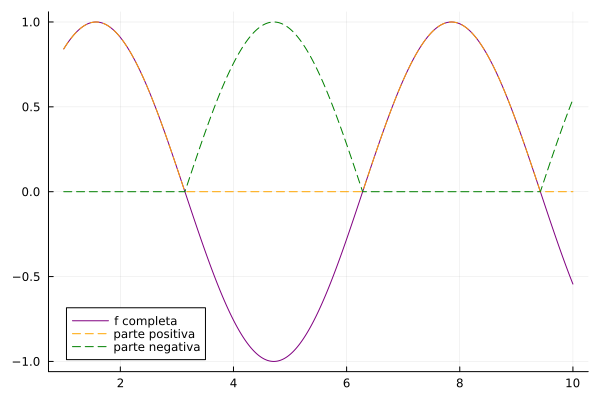

In [43]:
x_arr = 1:0.01:10
plot(sin, x_arr, label="f completa", color = "purple")

y_pos_arr = [max(sin(x), 0) for x in x_arr]
plot!(x_arr, y_pos_arr, label="parte positiva", ls = :dash, color = "orange")

y_neg_arr = [max(-sin(x), 0) for x in x_arr]
plot!(x_arr, y_neg_arr, label="parte negativa", ls = :dash, color = "green")

In [44]:
function integ(a, b, h, f)

    I = intpos(a, b, h, fplus(f)) - intpos(a, b, h, fminus(f))
    
    return I
end

integ (generic function with 1 method)

In [45]:
integ(pi, 2pi, 0.001, sin)

-1.9999998333333397

In [46]:
integ(-1, 1, 0.01, x -> x)

1.6653345369377348e-16

[4] Haz un objeto mutable Persona que tenga como propiedades: un identificador (Int) la edad (Int), el sex (Symbol),  el grado de enfermedad (Symbol), el número de días en el estado de la enfermedad (Int), la posición (Tuple{Real, Real}), una lista de conocidos (Vector{Int}). Además, importa Plots.plot y Plots.plot! para modificar estas funciones para que grafiquen una persona o una lista de personas usando su posición y su grado de enfermedad (con color que represente el grado de enfermedad). 

(Por como posibles grados de enfermedad :susceptible, :asintomático, :sintomas_leves, :sintomas_fuertes, :hospitalizado, :recuperado y :muerto). 

In [47]:
mutable struct Persona
    identificador :: Int
    edad :: Int
    sex :: Symbol
    grado :: Symbol
    tiempo :: Int
    posicion :: Tuple{Real, Real}
    conocidos :: Vector{Int}

end


In [48]:
grados_de_enfermedad = Dict(
    :susceptible     => :blue,
    :asintomático    => :yellow,
    :sintomas_leves  => :orange,
    :sintomas_fuertes=> :red,
    :hospitalizado   => :purple,
    :recuperado      => :green,
    :muerto          => :black
)


Dict{Symbol, Symbol} with 7 entries:
  :sintomas_leves   => :orange
  :recuperado       => :green
  :asintomático     => :yellow
  :hospitalizado    => :purple
  :sintomas_fuertes => :red
  :muerto           => :black
  :susceptible      => :blue

In [49]:
# este primero, nos pone el "plot" sobre el cuál podremos poner más "plots"

function p_plot(personas::Vector{Persona}; kwargs...)  # le vamos a dar una lista (un "array" de "personas")

    x = [i.posicion[1] for i in personas]  # la coordenada "x"
    
    y = [i.posicion[2] for i in personas]  # la coordenada "y"
    
    lista_de_colores = [grados_de_enfermedad[i.grado] for i in personas]  # del diccionario, tomamos la llave "i.grado" que va a la estructura "Persona" y nos da la llave correcta

    scatter(x, y, markercolor=lista_de_colores, legend=false; kwargs...)
end

# este segundo, nos permite sobreponer "plots" sobre el "plot" original
function p_plot!(personas::Vector{Persona}; kwargs...)

    x = [i.posicion[1] for i in personas]  # la coordenada "x"
    
    y = [i.posicion[2] for i in personas]  # la coordenada "y"
    
    lista_de_colores = [grados_de_enfermedad[i.grado] for i in personas]

    scatter!(x, y, markercolor=lista_de_colores, legend=false; kwargs...)
end

# hace lo mismo, sólo cambiamos el "!" para que sobreponga "plots"


p_plot! (generic function with 1 method)

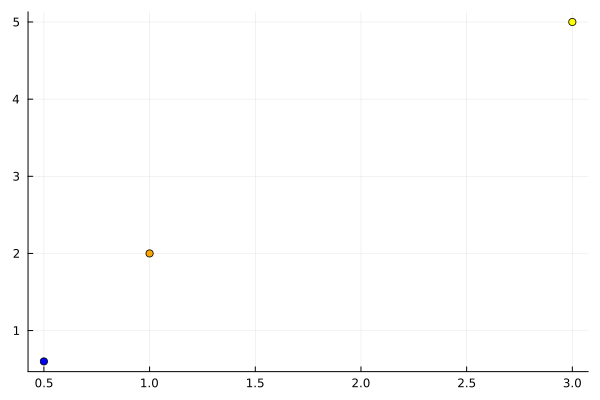

In [50]:
# a ver si funcionó

p1 = Persona(
                1,               # identificador
                20,              # edad
                :M,              # sex
                :susceptible,    # grado
                0,               # tiempo
                (0.5, 0.6),      # posicion
                []               # conocidos
                    )

p2 = Persona(
                2,
                22,
                :F,
                :sintomas_leves,
                2,
                (1, 2),
                []
                    )

p_lista1 = [p1, p2]

p_plot(p_lista1)

p3 = Persona(
                2,
                29,
                :F,
                :asintomático,
                3,
                (3, 5),
                []
                    )

p_lista2 = [p3]

p_plot!(p_lista2)

In [51]:
# hmmm... sólo no está graficando sobre el "plot" anterior como esperaba

[5] Modifica la función + para que si se suma una Tuple{Real, Real} a una persona, lo que se haga sea actualizar la posición de la persona, excepto si la persona está en estado :muerto. 

In [52]:
mutable struct Persona
    identificador :: Int
    edad :: Int
    sex :: Symbol
    grado :: Symbol
    tiempo :: Int
    posicion :: Tuple{Real, Real}
    conocidos :: Vector{Int}

end

In [ ]:
import Base.+  # porque sólo vamos a modificar esta operación (se usa "import" y no... "include", cierto? "include" era que importa toda la "librería"?)

+(p::Persona, t::Tuple{Real, Real}) = p.grado == :muerto ? p : Persona(p.identificador, 
p.edad, p.sex, p.grado, p.tiempo, p.posicion .+ t, p.conocidos)

+(t::Tuple{Real, Real}, p::Persona) = p.grado == :muerto ? p : Persona(p.identificador, 
p.edad, p.sex, p.grado, p.tiempo, p.posicion .+ t, p.conocidos)

+ (generic function with 515 methods)

In [54]:
(1, 2) .+ (2, 1)

(3, 3)

In [55]:
# "p3" tiene "3, 5"

# +(p3, (1, 1))

p3 + (1, 1)

Persona(2, 29, :F, :asintomático, 3, (4, 6), Int64[])

In [56]:
p4 = Persona(
                2,
                29,
                :F,
                :muerto,
                3,
                (3, 5),
                []
                    )

p_lista3 = [p4]


1-element Vector{Persona}:
 Persona(2, 29, :F, :muerto, 3, (3, 5), Int64[])

In [57]:
p4 + (1, 1)

Persona(2, 29, :F, :muerto, 3, (3, 5), Int64[])

In [58]:
(1, 1) + p4

Persona(2, 29, :F, :muerto, 3, (3, 5), Int64[])

[6] Haz una función de una sola línea que calcule la derivada automatica (para esto utiliza la representación matricial de un número dual https://en.wikipedia.org/wiki/Dual_number).

In [59]:
# de la clase tenemos que

In [60]:
mutable struct Dual <: Number
    i::Union{Real, Complex}
    d::Union{Real, Complex}
end 

In [61]:
import Base.+, Base.-, Base.*, Base./, Base.^

#=
se usa "import" cuando se requiere modificar y usar, y se usa "using" cuando sólo se quiere usar.
creo. eso le entendí al profe.
=#

+(d1::Dual, d2::Dual) = Dual(d1.i+d2.i, d1.d+d2.d)
-(d1::Dual, d2::Dual) = Dual(d1.i-d2.i, d1.d-d2.d)
*(d1::Dual, d2::Dual) = Dual(d1.i*d2.i, d1.i*d2.d+d2.i*d1.d)
/(d1::Dual, d2::Dual) = Dual(d1.i/d2.i, (d2.i*d1.d-d1.i*d2.d)/d2.i^2)
^(d1::Dual, d2::Dual) = Dual(d1.i^d2.i, d1.i^d2.i*(d2.d*log(d1.i)+d2.i* d1.d/d1.i))
+(d1::Dual, d2::Union{Real, Complex}) = Dual(d1.i+d2, d1.d)
+(d2::Union{Real, Complex},d1::Dual) = +(d1, d2)
-(d1::Dual, d2::Union{Real, Complex}) = Dual(d1.i-d2, d1.d)
-(d2::Union{Real, Complex},d1::Dual) =  Dual(d2-d1.i, d1.d)
*(d1::Dual, d2::Union{Real, Complex}) = Dual(d1.i*d2, d1.d*d2)
*(d2::Union{Real, Complex}, d1::Dual) = Dual(d1.i*d2, d1.d*d2)
/(d1::Dual, d2::Union{Real, Complex}) = Dual(d1.i/d2, d1.d/d2)
^(d1::Dual, d2::Union{Real, Complex}) = Dual(d1.i^d2, d2*d1.i^(d2-1)*d1.d)
^(d1::Dual, d2::Integer) = Dual(d1.i^d2, d2*d1.i^(d2-1)*d1.d)
/(d2::Union{Real, Complex}, d1::Dual) = *(d1^(-1), 1/d2)
^(d2::Union{Real, Complex}, d1::Dual) = Dual(d2^d1.i, d2^d1.i*log(d2)*d1.d)


^ (generic function with 137 methods)

In [62]:
#=

y siguiendo lo que sale en Wikipedia, tenemos la expressión

f(a + b * e) = f(a) + b * f'(a) * e

si tomamos "b=1", justo obtenemos "f'(a)" al evaluar la función que definamos en un dual de la forma "a + 1 * e".
así que hagamos eso.

=#

In [63]:
deriv(f, x) = f(Dual(x, 1)).d  # en una sóla línea. que... no me gusta porque no es tan claro. pero bueeeeeeeno.

#=

donde ".d" nos accede la parte "dual" que definimos en la estructura. y ya vimos que la parte dual es la derivada que buscamos.
".i" nos daría la función.
=#

deriv (generic function with 1 method)

In [64]:
# a ver si funcionó

f1(x) = (3x^2 + 2)

println("f1(2.0)= ", f1(2.0))
println("deriv(f1, 2.0) = ", deriv(f1, 2.0))

f1(2.0)= 14.0
deriv(f1, 2.0) = 12.0


[7] Haz una función de una sola línea que tenga como argumentos un entero y que arroje true o false dependiendo de si es el entero es un número primo o no. 

In [65]:
# para ver si es un número primo, tomamos

function es_primo(n)  # toma un entero como parámetro
    for i in 2:sqrt(n)
        if mod(n,i) == 0
            return false
        end
    end
    return true
end

# que vimos en clase.

es_primo (generic function with 1 method)

In [66]:
println(es_primo(3), es_primo(4))

truefalse


In [67]:
sum(0==0 for i in 1:4)

4

In [68]:
# y en una línea

es_primo_line(n) = (n == 2 || n == 3 || sum(mod(n,i) == 0 for i in 2:sqrt(n)) == 0) ? true : false

#=
hay que agregar los casos "n = 2, 3" porque como definimos el "for" que va de "2" a "sqrt(n)",
para estos valores tendríamos que "sqrt(n) < 2", pero estos sí son números primos.
y hay que definir el caso cuando "n = 1" porque ese no se define como un número primo.
=#

#=
así como vimos que "||" es el "or", de la documentación vemos que "&&" es el "and" en los condicionales.
así que tomemos "1 < n" y listooooooo
=#

es_primo_line(n) = (n > 1 && (n == 2 || n == 3 || sum(mod(n,i) == 0 for i in 2:sqrt(n)) == 0)) ? true : false

#=
nos faltó poner que se cumpliera que "n > 1" y que todo lo demás que teníamos se cumpliera. 
fue importante poner ese paréntesis para especificar qué se cumple.

probablemente hay una forma un poquito más corta de hacer esta función, sin tantas condiciones.
=#


es_primo_line (generic function with 1 method)

In [69]:
es_primo_line(1)

false

[8] Utilizando la función anterior, haz una función $\pi_p(x)$ de una sola línea que cuente el número de números primos  menores o iguales que $x$. Luego aplícala a $x \in [2, 10000]$ y grafica $\pi_p(x)$ contra $x$ y $\frac{x}{\log(x)}$ contra $x$ en la misma gráfica para checar qué tan bien funciona el teorema del número primo. 

¿Qué tan bien aproxima $\frac{x}{\log(x)}$ a $\pi_p(x)$?

In [70]:
function pi_p(x)

    c = 0

    for i in 2:x

        if es_primo_line(i) == true

            c += 1
        
        end

    end

    return c

end

# sumas de booleanos dan "0" y "1"

pi_p (generic function with 1 method)

In [71]:
es_primo_line(3) == true

true

In [72]:
pi_p(10000)

1229

In [112]:
x_eje = 1:2000

y_eje = [pi_p(i) for i in x_eje];

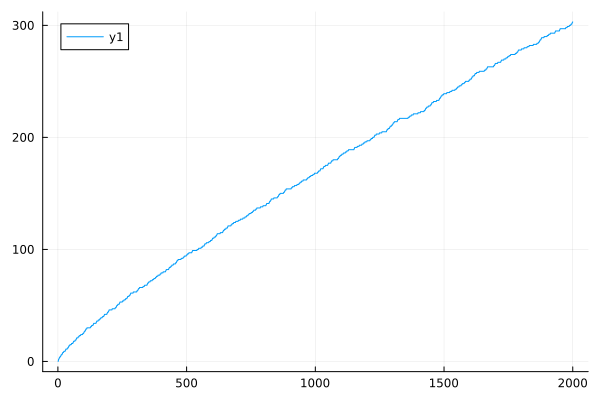

In [113]:
plot(x_eje, y_eje)

In [114]:
function compara_p(x)
    return x/log(x)
end

compara_p (generic function with 1 method)

In [115]:
y_comp_eje = [compara_p(i) for i in x_eje];

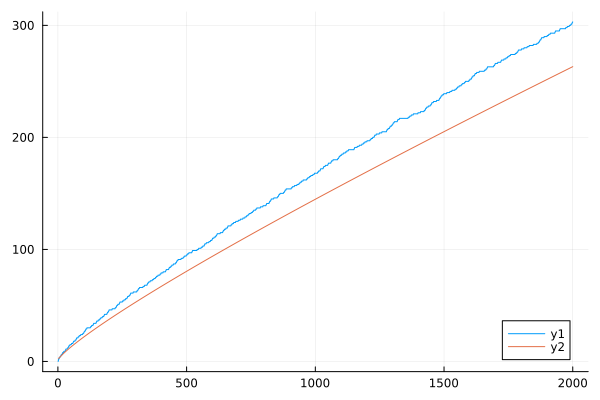

In [116]:
plot!(x_eje, y_comp_eje)

In [78]:
# no aproxima bien

[9] Haz una función que dada una imagen, modifique sus pixeles agregando o quitando aleatoriamente más rojo, verde o azul. Pensemo que los colores r g y b, estos son números entre 0 y 1. Si alguno de estos colores (por ejemplo r) se excede de 1, entonces debe de arrojar r = 1- parte decimal de r, mientras que si es menor que 0, debe arrojar r = parte decimal de abs(r). 

In [79]:
amigos1 = load("lmp.JPG")


s_ami = size(amigos1)  # "size = (3456, 5184)"

println(typeof(amigos1), typeof(s_ami))

Matrix{RGB{N0f8}}Tuple{Int64, Int64}


In [80]:
amigos1[1,1]

In [81]:
amigos2 = [Float64(amigos1[i, j].r) + rand() for i in 1:s_ami[1], j in 1:s_ami[2]];

In [82]:
;amigos2 = zeros(s_ami[1], s_ami[2]);

[10] Con la función anterior haz un video de donde produzca imágenes cada 100 modificaciones a los pixeles y hasta haber modificado 10 en promedio cada pixel (se debe ver como la entropía termina destruyendo la imágen). 

## Ecuaciones diferenciales

Aquí puedes usar lo que quieras para resolver la tarea. Sobre el uso de AI's, es algo suficientemente nuevo como para que no sepa si es conveniente para su aprendizaje. Mi recomendación es que intenten lo más posible sin, aunque si sólo la usan para acelerar lo que ya saben hacer bien, creo que puede ser una buena herramienta. Les recomiendo también siempre darle el toque con su estilo de programación, es decir, "corregir" lo que la AI haga para que quede "como ustedes lo harían". 

Si puedes usa la paquetería DifferentialEquations, te será práctico en un futuro. 

[11] Modelo SIR (Susceptibles Infectador Recuperados). El modelo considera que existen sólo 3 poblaciones, susceptibles, infectados y recuperados. Los recuperados son los que dejan de estar infectados. Lo hacen en una tasa proporcional a la población de infectados y una vez recuperados ya no pueden cambiar de estatus. Los infectados crecen a una tasa que es proporcional a la población de susceptibles y a la de infectados y decrecen a la misma tasa a la que crecen los recuperados. Finalmente, los susceptibles decrecen a la misma tasa en la que crecen los infectados. Es decir: $\dot{S} = -\alpha SI$, $\dot{I} = \alpha SI - \beta I$ y $\dot{R} = \beta I$. 

Programa el model SIR (como visto en la clase), obteniendo el número de infectados como función del tiempo. Ajusta los datos dela primera parte (antes de alcanzar un máximo) con una ley de potencias y una exponencial. ¿Cuál ajusta mejor? 

Además, busca qué distribución ajusta mejor a $I$. 


Grafica tus resultados

In [200]:
# las constantes (los parámetros del modelo)

α = 0.40
β = 0.1
δ = 0.01

0.01

In [201]:
#=
la función que contiene las derivadas.
como "DifferentialEquations" pide que esta función tenga los parámetros "(du, u, p, t)",
debemos modificar la que vimos en clase. 
=#

g(x,t) = [-α*x[1]*x[2], α*x[1]*x[2]-β*x[2], β*x[2]]

#=
es decir, también debemos "introducir" las constantes (definidas arriba) en la nueva función mediante el parámetro "p" (como lo hace en el notebook de la clase).
=#

function sir!(du, u, p, t)  # lo ponemos con "!" porque así estaba en el notebook su otraa función. preo creo se pone cuando se modifica uno de los parámetros de la función (se usa por convención)

    α, β = p  # que si le damos una tupla al parámetro "p", esto le asigna una variable a cada elemento de la tupla (de forma ordenada)

    S, I, R = u  # lo que hace es análogo a la línea de código anterior, sólo que "u" contiene el estado actual de la solución (de forma vectorizada). es decir, comienza con las condiciones iniciales.
    # lo anterior lo hizo el profe con "slicing".

    # y ahora toca definir las "entradas" de la "derivada vectorizada". es decir:
    du[1] = -α * S * I
    du[2] = α * S * I - β * I
    du[3] = β * I

end


sir! (generic function with 1 method)

In [202]:
#=
y ahora vamos a ver los parámetros de "ODEProblem":

ODEProblem(F, u0, tspan, p)
=#

In [203]:
# ya definimos "F" como "sir!".

In [204]:
# la condición inicial (vectorizada) es

u0 = [1.0 - δ, δ, 0]  # deberíamos definir antes el parámetro "δ" pero vamos a dejar lo que él puso en el notebook y mantener un orden de los parámetros de "ODEProblem".

3-element Vector{Float64}:
 0.99
 0.01
 0.0

In [205]:
# el intervalo de integración

tspan = (0.0, 300.0)

(0.0, 300.0)

In [ ]:
# los parámetros son

p = (α, β, δ)

(0.4, 0.1, 0.01)

In [207]:
# y ahora sí, usemos el integrador.

In [208]:
problema = ODEProblem(sir!, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 300.0)
u0: 3-element Vector{Float64}:
 0.99
 0.01
 0.0

In [209]:
sol_tot = solve(problema, PFRK87(), adaptive=false, dt = 0.1)

#así se accede a la solución obtenida
sol_u = sol_tot.u;

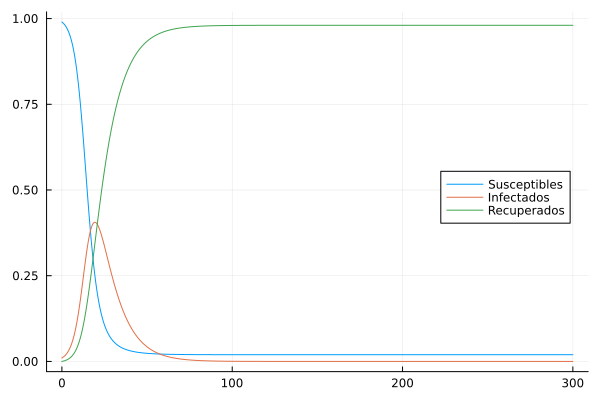

In [210]:
# y grafiquemos como

t_val = sol_tot.t 

sol_S = [u[1] for u in sol_tot.u]
sol_I = [u[2] for u in sol_tot.u]
sol_R = [u[3] for u in sol_tot.u];

plot(t_val, sol_S, label = "Susceptibles")
plot!(t_val, sol_I , label = "Infectados", key = :right)
plot!(t_val, sol_R , label = "Recuperados")

In [211]:
# nos faltan los ajustes, perdón

[12] Modelo SIRS. El modelo SIR sirve sólo para enfermedades donde no puede haber reíncidencia. Una corrección simple a este modelo consiste en agregar una probabilidad de que los recuperados pasen a ser susceptibles nuevamente. Corrigen las ecuaciones para incluir ahora una proporción $\gamma$ de recuperados que pasan a ser susceptibles y haz las correspondientes simulaciones. 

Juega con los parámetros y condiciones iniciales. 

Grafica tus resultados. 

In [212]:
# análogo al último problema, definimos las cosas que ocupamos (en un orden)

In [213]:
function sirs!(du, u, p, t)

    α, β, γ = p
    
    S, I, R = u

    du[1] = -α * S * I + γ * R  # la modificación está en que una proporción "γ" de recuperados que pasan a ser susceptibles (por eso se suma este término)
    du[2] =  α * S * I - β * I
    du[3] =  β * I - γ * R  # y pues la proporción "γ" de recuperados que pasó a ser suceptible, se debe restar de aquí

end

sirs! (generic function with 1 method)

In [214]:
u0_2 = [1.0 - δ, δ, 0]  # lo puso así porque todos deben sumar "1"? aún así, usamos la misma "δ" que antes.

3-element Vector{Float64}:
 0.99
 0.01
 0.0

In [215]:
tspan_2 = (0.0, 300.0)

(0.0, 300.0)

In [216]:
p_2 = (α, β, δ)

(0.4, 0.1, 0.01)

In [217]:
problema_2 = ODEProblem(sirs!, u0_2, tspan_2, p_2)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 300.0)
u0: 3-element Vector{Float64}:
 0.99
 0.01
 0.0

In [218]:
sol_tot_2 = solve(problema_2, PFRK87(), adaptive=false, dt = 0.1)

#así se accede a la solución obtenida
sol_u_2 = sol_tot_2.u;

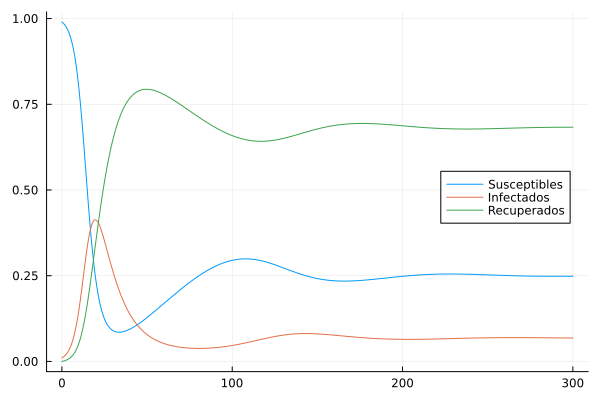

In [230]:
# y grafiquemos como

t_val_2 = sol_tot_2.t 

sol_S_2 = [u[1] for u in sol_tot_2.u]
sol_I_2 = [u[2] for u in sol_tot_2.u]
sol_R_2 = [u[3] for u in sol_tot_2.u];

plot(t_val_2, sol_S_2, label = "Susceptibles")
plot!(t_val_2, sol_I_2, label = "Infectados", key = :right)
plot!(t_val_2, sol_R_2, label = "Recuperados")

[13] Ahora haz una modificación al modelo anterior para elimiar la posibilidad de tener el estado intermedio "Recuperados". ¿Como se comparar ambos modelos?  

In [246]:
δ_3 = 0.5 * δ  # cambiemos tantito la "δ"

0.005

In [247]:
function si!(du, u, p, t)
    α = p  # ya sólo queda un parámetro
    S, I = u  # porque ya no tiene la parte de los recuperados
    du[1] = -α * S * I  # porque ya no tiene la parte de los recuperados
    du[2] =  α * S * I  # no tiene el "- β * I" porque "β" era un parámetro de los recuperados (que ya no están. rip)
                        # y pues, la tercer "componente" de "du" tampoco está porque ya no hay recuperados.
end

si! (generic function with 1 method)

In [248]:
u0_3 = [1.0 - δ_3, δ_3]  # lo puso así porque todos deben sumar "1"?
# igual, nota que ya sólo hay dos "entradas" en la condición inicial

2-element Vector{Float64}:
 0.995
 0.005

In [249]:
tspan_3 = (0.0, 300.0)

(0.0, 300.0)

In [250]:
p_3 = (α)  # ya sólo queda el parámetro "α"

0.4

In [251]:
problema_3 = ODEProblem(si!, u0_3, tspan_3, p_3)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 300.0)
u0: 2-element Vector{Float64}:
 0.995
 0.005

In [252]:
sol_tot_3 = solve(problema_3, PFRK87(), adaptive=false, dt = 0.1)

#así se accede a la solución obtenida
sol_u_3 = sol_tot_3.u;

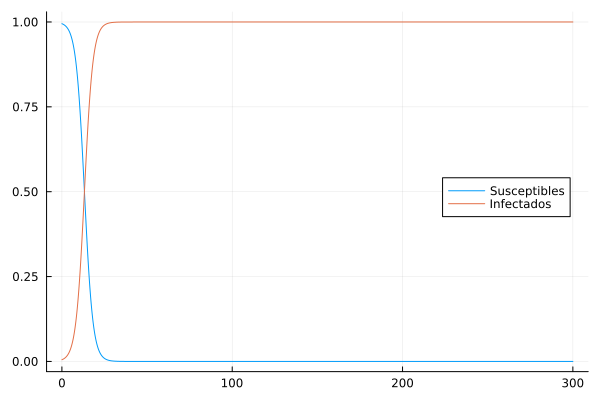

In [253]:
# y grafiquemos como

t_val_3 = sol_tot_3.t 

sol_S_3 = [u[1] for u in sol_tot_3.u]
sol_I_3 = [u[2] for u in sol_tot_3.u];

plot(t_val_3, sol_S_3, label = "Susceptibles")
plot!(t_val_3, sol_I_3, label = "Infectados", key = :right)

In [228]:
# y a ver cómo se comparan

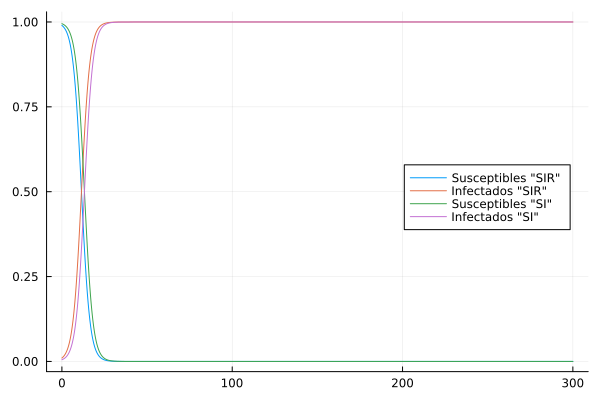

In [254]:
# grafiquemos sobre el mismo intervalo

plot(t_val_3, sol_S, label = """Susceptibles "SIR" """)
plot!(t_val_3, sol_I, label = """Infectados "SIR" """)

#=
plot!(t_val_3, sol_S_2, label = """Susceptibles "SIRS" """)
plot!(t_val_3, sol_I_2, label = """Infectados "SIRS" """)
=#

plot!(t_val_3, sol_S_3, label = """Susceptibles "SI" """)
plot!(t_val_3, sol_I_3, label = """Infectados "SI" """, key = :right)

In [ ]:
# se parecen bastante...

[14] Modelo de infección celular. Si ahora queremos estudiar como se propaga la enfermedad en un tejido celular, podemos estudiar una población $U$ de células susceptibles, una de virus $V$ y una población de células infectadas. Las células sanas crecen con una tasa más o menos constante $S_u$, y mueren a una tasa $d_U$ que es proporcional al número de células sanas. Además, las células sanas pasan a ser infectadas a una tasa proporcional al número de virus y al número de células sanas. Además, las células infectadas mueren a una tasa proporcional a las células infectas. Finalmente, los virus se reproducen a una tasa que es proporcional a las células infectadas y mueren a una tasa proporcional a la población de virus. 

Escribe las ecuaciones diferenciales correspondientes y haz la simulación. Utiliza parámetros que sean razonables (explica por qué es razonable tu elección de parámetros). 

Grafica tus resultados

In [ ]:
# otra vez, el problema es definir bien la derivada vectorizada. así que comencemos con eso con una estructura similar a las anteriores.

In [256]:
function modelo_celular!(du, u, p, t)
    
    S_u, d_U, k, d_I, r, d_V = p
    #=
    tasa "constante" de crecimiento de células no infectadas,
    tasa de muerte de células infectadas,
    una constante de proporcionalidad (respecto de ambos tamaños de población no infectada e infectada),
    tasa de muerte de células infectadas,
    otra constante de proporcionalidad (de la reproducción del virus),
    tasa de muerte del virus
    =#

    U, I, V = u
    
    du[1] = S_u - d_U * U - k * U * V
    du[2] = k * U * V - d_I * I
    du[3] = r * I - d_V * V
end

modelo_celular! (generic function with 1 method)

In [257]:
u0 = [10, 0, 1]  # 10 células no infectadas, 0 infectadas, 1 virus

3-element Vector{Int64}:
 10
  0
  1

In [258]:
tspan = (0, 300)

(0, 300)

In [259]:
S_u = 1
d_U = 0.1
k   = 0.05
d_I = 0.2
r   = 5
d_V = 1

1

In [260]:
p_cel = (S_u, d_U, k, d_I, r, d_V)

(1, 0.1, 0.05, 0.2, 5, 1)

In [265]:
problema_15 = ODEProblem(modelo_celular!, u0, tspan, p_cel);

In [264]:

sol  = solve(problema_15, PFRK87(), adaptive=false, dt = 0.1);

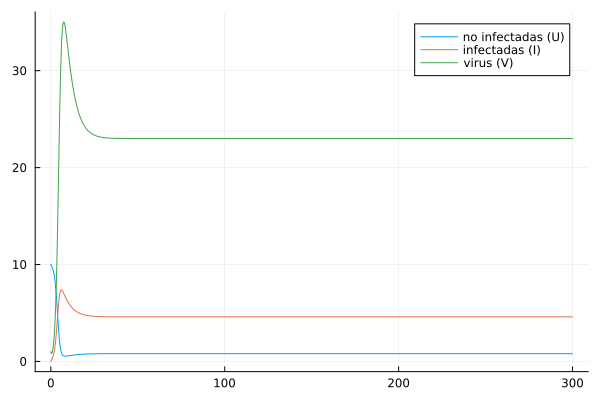

In [266]:
t_val = sol.t
U_val = [u[1] for u in sol.u]
I_val = [u[2] for u in sol.u]
V_val = [u[3] for u in sol.u]

plot(t_val, U_val, label="no infectadas (U)")
plot!(t_val, I_val, label="infectadas (I)")
plot!(t_val, V_val, label="virus (V)")

[15] Modelo con nacimientos y muertes: Otra modificación al modelo SIR, es considerar que la población está creciendo. En este caso, habrá una tasa de crecimiento de la población proporcional a la población completa (S, I y R). Los que nacen, nacen susceptibles. Además, hay una taza de muertes que es proporcional a los infectados y otra tasa de muerte que es proporcional a los no infectados. De ahí en fuera, todo más o menos igual al modelo SIR. Haz la simulación y estudia cualitativamente qué diferencias hay con el modelo SIR, en particular ¿Se llega a un estado estacionario de todas las poblaciónes? 

[16] Modelo SEIR. Un modelo también común es considerar un estado intermedio entre la suceptibilidad y la infección. Ese estado intermedio es el de los que están expuestos. Los expuestos tienen el virus, pero no se han infectado. Alunos pasan a estar infecciosos más rápidos que otros (considerando tiempos de incuvación). Así que modicamos el modelo anterior agregando la población de expuetos. La tasa de expuestos será proporcional a la población de susceptibles y a la de infectados y decreserá por las muertes (como todos) y por una tasa de paso a la infección. Los infectados crecen por los expuestos que pasan a ser infecciosos y decrese por las muertes y por una tasa de infecciosos que pasan a recuperarse.  Los recuperados se generan por los infecciosos que se recuperaron y decrecen por los que mueren. 

Escribe las ecuaciones de este modelo y resuelvelas numériamente. Juega con los parámetros y justifica tus elecciones de parámetros. 

¿Siempre se llega a un estado estacionario?



[17] Escribe y resuelve las ecuaciones del péndulo doble. Haz una animación (video) con tu sulución. Recueda que si no lo resuelves con un método simpléctico (no vas a poder), entonces la energía de tu sistema tiende a aumntar. Tedrás que hacer alguna corrección para que tu animción sea realista por un tiempo no tan corto. 

[18]  (La explicación es larga, pero el problema es en realidad fácil): Uno de los primeros modelos de neuronas que se hizo fue el de Hodgkin–Huxley por el cual ambos recibieron el premio Nobel en 1963 y hoy en día este modelo sigue usándose para estudiar el comportamiento de las neuronas en el cerebro. Este modelo considera a cada neurona como un circuito eléctrico donde la superficie de la célula forma un capacitor, y dentro tiene una serie de canales de sodio y potacio que efectivamente forman 3 tipos de resistencias variables (dependen del voltage). 

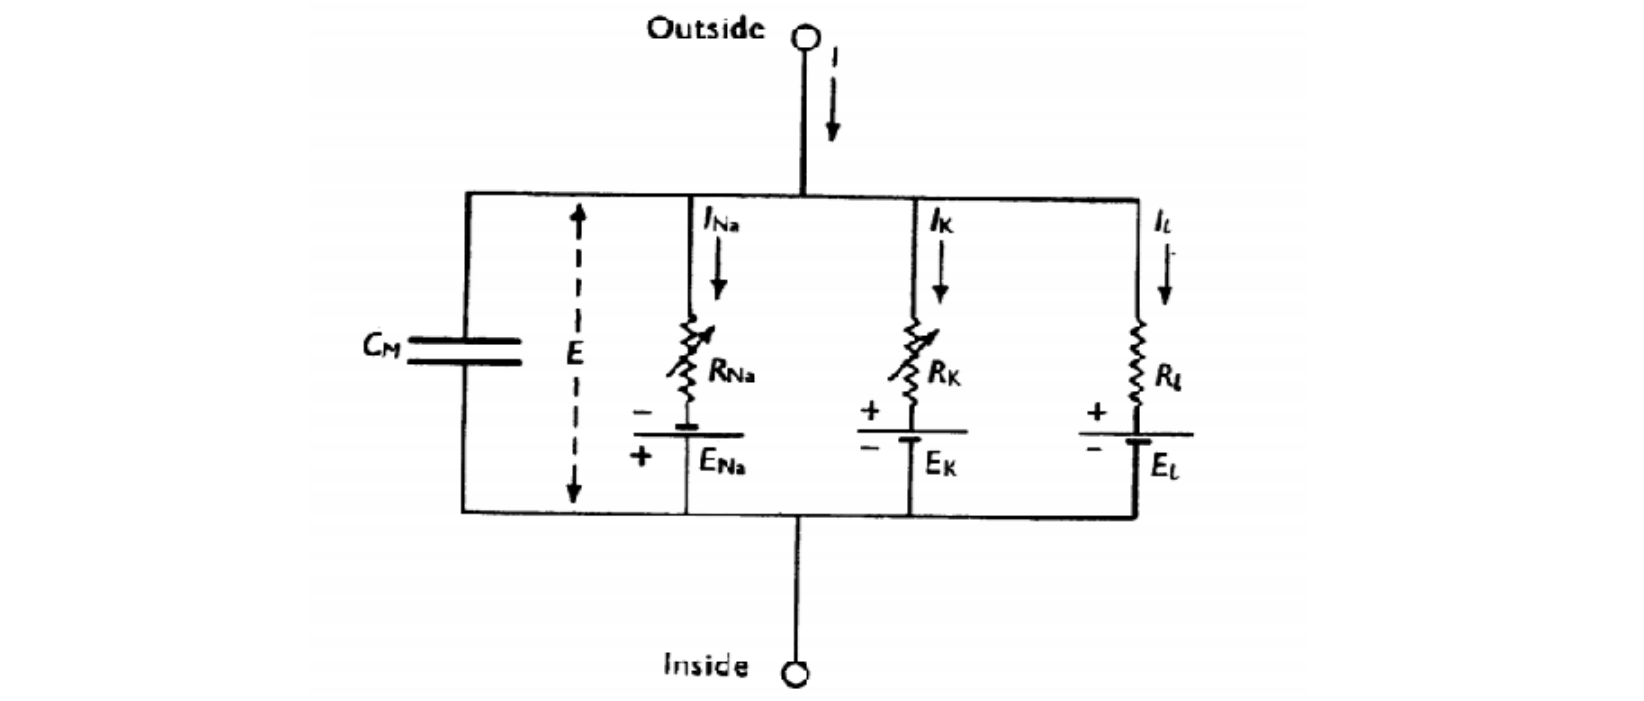

En este circuito las $E_{algo}$ son constantes, igual que $C_m$ y $g_l$. Pero las $g_{Na}$ y $g_K$ no son constantes. Sin embargo se pueden expresar como funciones de los canales de conducción $n$, $m$ y $h$ que representan los canales de potacio, sodio y de fuga respectivamente. Al final la ecuación diferencial que define este circuito es: 
  
$$I = C_m \frac{dV_m}{dt} +g_K n^4 (V_m -V_K) + g_{Na} m^3 h (V_m - V_{Na}) + g_l (V_m -V_l).$$

Aquí $g_K$ y $g_{Na}$ ya son constantes (en realidad son los promedios de las conductividades de potacio y sodio respectivamente). $n$, $m$ y $h$ por otra parte está modelados por: 

$$\frac{dn}{dt} = \alpha_n(V_m) (1-n) - \beta_n(V_m) n, $$

$$\frac{dm}{dt} = \alpha_m(V_m) (1-m) - \beta_m(V_m)m, $$

$$\frac{dh}{dt} = \alpha_h(V_m) (1-h) - \beta_h(V_m)h, $$

donde $\alpha_n(V_m) = \frac{0.01 (10-V_m}{e^{(10-V_m)/10} -1}$, $\alpha_m(V_m) = \frac{0.1 (25-V_m}{e^{(25-V_m)/10} -1}$,
$\alpha_h(V_m) = 0.07 e^{V_m /10}$, $\beta_n(V_m) = 0.125 e^{V_m/80}$, $\beta_m(V_m) = 4 e^{V_m/18}$ y $\beta_h(V_m) = \frac{1}{e^{(30+V_m)/10}+1}$. 

En su artículo Hodgkin y Huxley utilizan los valores $C_m = 1.0$, $V_K \approx 12$, $V_{Na} \approx -115$, $V_l \approx -10.613$, $g_K \approx 36 $, $g_{Na}\approx 120 $ y $g_l \approx 0.3$. 

Además, la corriente y el voltaje están relacionados vía la siguiente ecuación diferencial parcial: 

$$ I = \frac{a}{2R_2} \frac{\partial ^2 V}{\partial x^2} $$

donde $R_2$ es la resistencia del axón y $a$ es el radio de la fibra de conducción del axón, ambos valores son constantes. 

El que se obtenga una ecuación diferencial parcial es molesto, pero si la propagación de la corriente es constante, entonces variar con respecto de la posición el voltaje corresponde a variar con respecto del tiempo, es decir:  

$$ I = \frac{a}{2R_2} \frac{\partial ^2 V}{\partial x^2} \approx  \frac{a}{2R_2 \Theta ^2}\frac{\partial^2 V}{\partial t^2},$$

donde $\Theta$ es la velocidad de conducción de los iones y es una constante por hipótesis. Por lo que la primera ecuación queda como (fijando $x$ para el voltaje y corriente de salida): 

$$\frac{a}{2R_2 \Theta ^2}\frac{d^2 V_m}{d t^2} = C_m \frac{dV_m}{dt} +g_K n^4 (V_m -V_K) + g_{Na} m^3 h (V_m - V_{Na}) + g_l (V_m -V_l).$$

Donde $\frac{a}{2R_2 \Theta ^2} \approx 10.47 C_m $. 

Dicho todo esto, en este ejercicio se pide que resuelvas esta última ecuación diferencial para obtener  $V_m$ (y por lo tanto $I$) como función del tiempo dado un potencial inicial $V_0$. Utiliza un "buen método" para resolver la ecuación (o sea, no Euler). Recuerda que siempre puedes escribir una ecuación de segundo orden como un sistema de ecuaciones de primer orden.  

**Nota:** Este modelo permite en principio conectar varias neuronas en una red. Entonces, se activa una neurona cualquiera con un potencial inicial suficientemente grande. Eso generará un potencial de salida que activará otras neuronas y así se puede propagar una "onda cerebral". Hay marcapasos cerebrales que simplificadamente detectan determinadas ondas cerebrales y con este modelo generan una "onda inversa" que anule (parte de) la primera. El propósito de estos marcapasos es eliminar sobre-exitación de algunas neuronas que tienen como efecto generar temblorina (resultado de Parkinson). Pueden ver un video de como se ven en funcionamiento estos marcapasos aquí (es INCREÍBLE): https://www.youtube.com/watch?v=34XP72FuvnQ.  

[19] Modelo epidemeológico de la CDMX para COVID: Revisa aquí: https://modelo.covid19.cdmx.gob.mx/modelo-epidemico el modelo epidemeológico de la CDMX. Escribe las ecuaciones, con los parámetros que ahí dan y resuelve el modelo. 

Trata también de explicar porque ponen esas ecuaciones. ¿Vale la pena un modelo separado en tantas poblaciones? 

[20] Resuelve las ecuaciones del atrctorde Lorenz y haz una animación... Hay $n$ soluciones a este problema en internet. Trata de hacer tu versión sin copiar alguna de las de internet, el problema es fácil, pero tiene su chiste elegir los buenos parámetros, así que antes de copiar una solución de internet, intenta por ti mismo encontrar lo que encontró Lorenz.  